In [4]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from glob import glob

In [3]:
TRAIN_DIR = 'preprocessed-tea-leaf-dataset/train'
TEST_DIR = 'preprocessed-tea-leaf-dataset/test'

In [49]:
ready_train = glob(TRAIN_DIR + ('/ready/*.JPG'))
not_ready_train = glob(TRAIN_DIR + ('/not-ready/*.JPG'))
ready_test = glob(TEST_DIR + ('/ready/*.JPG'))
not_ready_test = glob(TEST_DIR + ('/not-ready/*.JPG'))

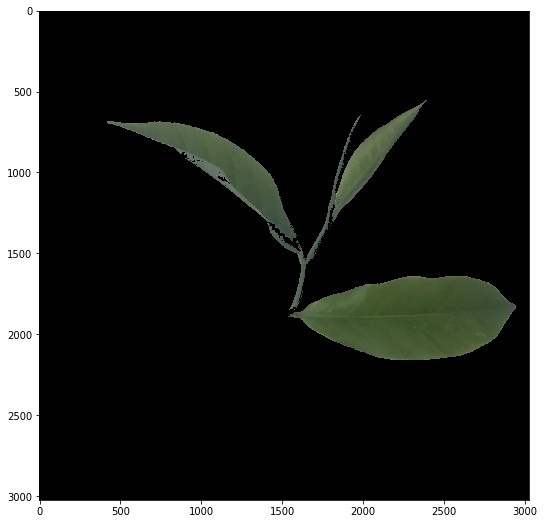

In [53]:
ready = np.random.choice(ready_train, 1)
plt.figure(figsize=(12,9))
plt.imshow(np.asarray(Image.open(ready[0]).convert('RGB')))

In [54]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input

Using TensorFlow backend.


In [56]:
CLASSES = 2

base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False
  
  
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import load_model

In [58]:
WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 957 images belonging to 2 classes.
Found 318 images belonging to 2 classes.


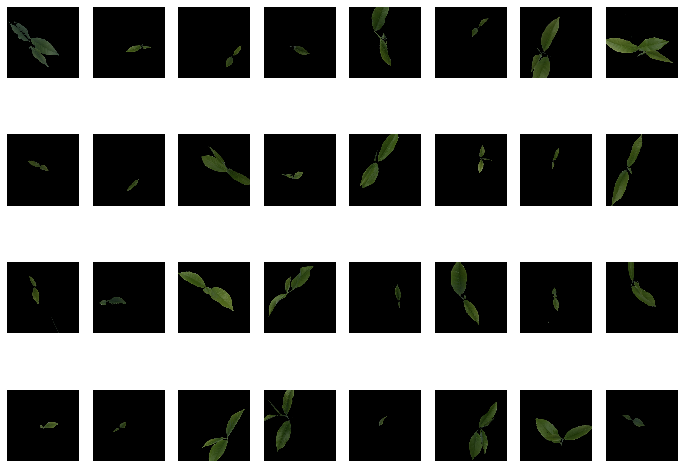

In [59]:
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

In [60]:
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'inception_tea.model'

history = model.fit_generator(train_generator,
                             epochs=EPOCHS,
                             steps_per_epoch=STEPS_PER_EPOCH,
                             validation_data=validation_generator,
                             validation_steps=VALIDATION_STEPS)
model.save(MODEL_FILE)

W0816 11:30:36.903806 140375152162624 deprecation.py:323] From /home/hashan/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
320/320 [==============================] - 2083s 7s/step - loss: 0.2118 - acc: 0.9172 - val_loss: 0.1818 - val_acc: 0.9528
Epoch 2/5
320/320 [==============================] - 2040s 6s/step - loss: 0.1040 - acc: 0.9619 - val_loss: 0.1512 - val_acc: 0.9455
Epoch 3/5
320/320 [==============================] - 2043s 6s/step - loss: 0.0858 - acc: 0.9678 - val_loss: 0.2571 - val_acc: 0.8923
Epoch 4/5
320/320 [==============================] - 2041s 6s/step - loss: 0.0838 - acc: 0.9690 - val_loss: 0.2407 - val_acc: 0.8983
Epoch 5/5
320/320 [==============================] - 2034s 6s/step - loss: 0.0750 - acc: 0.9723 - val_loss: 0.1478 - val_acc: 0.9508


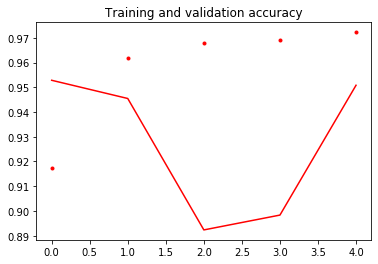

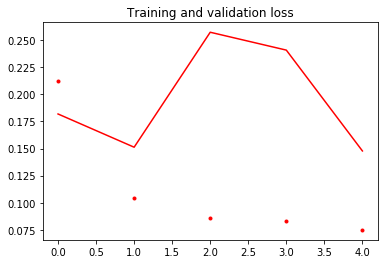

In [61]:
def plt_training(histroy):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title("Training and validation accuracy")
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r')
  plt.title('Training and validation loss')
  plt.show()
  
plt_training(history)

In [87]:
def predict(model, img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

In [92]:
def plot_preds(img, preds):
    # to find the labels in the model use - train_generator.class_indices
    labels = ("not-ready", "ready")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[1])
    plt.barh([0,1], preds, alpha=0.5)
    plt.yticks([0,1], labels)
    plt.xlabel('Probability')
    plt.xlim(0,1)
    plt.tight_layout()

In [73]:
model = load_model(MODEL_FILE)

array([9.993179e-01, 6.821368e-04], dtype=float32)

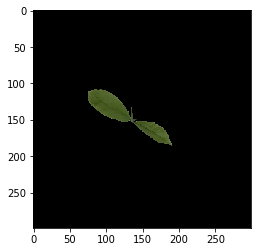

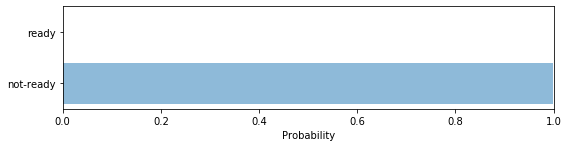

In [93]:
img = image.load_img('test1.JPG', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)
plt.imshow(np.asarray(img))
plot_preds(np.asarray(img), preds)
preds